In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import rnnInput as inp
from matplotlib import pyplot as plt
from tensorflow.contrib import learn
import time as t
from lstm import lstm_model as lstm

#parametros da rede
TIMESTEPS = 1
RNN_LAYERS = [{'num_units': 2}]
TRAINING_STEPS = 1000
DENSE_LAYERS = None
LOG_DIR = None
BATCH_SIZE = 100

#configuraçõess d gpu
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.4)
config = tf.ConfigProto()
config.allow_soft_placement=True
config.log_device_placement=True
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.Session(config=config)

#parametros da amostra
length=1000
#geracao de dados
X, y = inp.generate_data(np.sin, np.linspace(0, 100, 1000, dtype=np.float32), TIMESTEPS, seperate=False)

In [2]:
#inicializacao da rede, monitor de validação e inicio de treinamento
with tf.device('/gpu:0'):
    regressor = learn.Estimator(model_fn=lstm(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS),
                            model_dir=LOG_DIR)
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=1000,
                                                     early_stopping_rounds=1000)
with tf.device('/gpu:0'):
    regressor.fit(X['train'], y['train'], 
              monitors=[validation_monitor], 
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

C:\Users\freak\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


C:\Users\freak\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


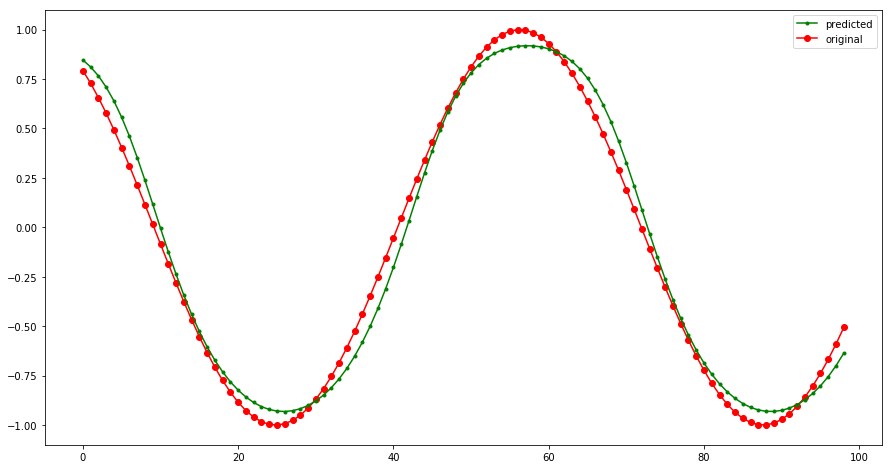

In [3]:
#geracao de predict
predicted = regressor.predict(X['test'])
predictedArr = np.array(list(predicted))
predictedArr.shape=-1,1
#predictedDataFrame=pd.DataFrame(predictedArr)
plt.figure(figsize=(15,8))
plot_test, = plt.plot(y['test'], label='original', marker='o', color='r')
plot_predicted, = plt.plot(predictedArr, label='predicted',marker='.', color='g')
plt.legend(handles=[plot_predicted, plot_test])

In [8]:
#teste geracao predict completo
def predizer(qtd,inicio):
    #a funcao requer um inicio com o length minimo de TIMESTEPS+1
    inicial=pd.DataFrame(inicio[inicio.size-TIMESTEPS-1:])
    inicial.reset_index(drop=True)
    qtd+=TIMESTEPS
    data_test=inp.rnn_data(inicial,TIMESTEPS)
    Tpredicted = regressor.predict(data_test)
    predictedArr = np.array(list(Tpredicted))
    entraRaw = inicial.append(pd.DataFrame(predictedArr),ignore_index=True)
    entraRaw=entraRaw[entraRaw.size-TIMESTEPS-1:] 
    entraRaw=entraRaw.reset_index(drop=True)
    entrada = inp.rnn_data(entraRaw,TIMESTEPS)
    qtd-=1
    i=0
    tempoInicial = t.time()
    tempot = tempoInicial
    retorno = pd.DataFrame(inicio)
    retorno = retorno.append(pd.DataFrame(predictedArr))
    while(qtd>TIMESTEPS):
        i=i+1
        with tf.device('/gpu:0'):
            Tpredicted = regressor.predict(entrada)
        predictedArr = np.array(list(Tpredicted))
        entraRaw = entraRaw.append(pd.DataFrame(predictedArr),ignore_index=True)
        entraRaw=entraRaw[entraRaw.size-TIMESTEPS-1:]
        entraRaw=entraRaw.reset_index(drop=True)
        entrada = inp.rnn_data(entraRaw,TIMESTEPS)
        retorno = retorno.append(pd.DataFrame(predictedArr),ignore_index=True)
        qtd-=1
        tempoTrain = t.time() - tempot
        tempot = t.time()
        print("passo n.: ",i,"tempo do passo: ",tempoTrain)
    tempoTotal = t.time() - tempoInicial
    print("tempo total da predição: ",tempoTotal)
    retorno.reset_index(drop=True)
    return retorno

    

In [13]:
#exemplo predict recursivo
#é necessario gerar uma amostra inicial do tamanho de TIMESTEPS+1
J, k = inp.generate_data(np.sin, np.linspace(0, 100, 1000, dtype=np.float32),TIMESTEPS, seperate=False) 
k['test']=k['test'][k['test'].size-TIMESTEPS-1:]
print('valores iniciais para o predict {}'.format(k['test']))
print("iniciando predict recursivo")
entraPredizer = pd.DataFrame(k['test'])
pred=predizer(5,entraPredizer)


valores iniciais para o predict [[-0.59000301]
 [-0.50636566]]
iniciando predict recursivo


C:\Users\freak\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


passo n.:  1 tempo do passo:  1.488694190979004
passo n.:  2 tempo do passo:  1.345165729522705
passo n.:  3 tempo do passo:  1.6172058582305908
passo n.:  4 tempo do passo:  1.5742080211639404
tempo total da predição:  6.02527379989624


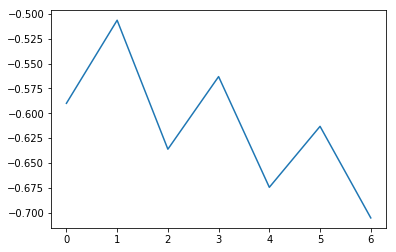

In [10]:
plt.plot(pred)